In [102]:
import warnings
import itertools
import pandas as pd
import plotting as mp
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from data_wrangling import Results_data, Data_preparation
from collections import OrderedDict
from results_plotting import Sarima_predictions, line_plot_predictions, baseline_forecasts
from baseline_models import Baseline_previous, Baseline_average
plt.style.use('fivethirtyeight')

In [119]:
def plot_results(df):
    cross_val_scores = {}
    cross_val_scores['baseline_previous'] = df.iloc[0]['baseline_previous']
    cross_val_scores['baseline_average'] = df.iloc[0]['baseline_averages']
    cross_val_scores['sarima'] = df.iloc[0]['sarima_x']
    cross_val_scores['sarimaX_fixed'] = df.iloc[1]['sarima_x']
    cross_val_scores['sarimaX_variable'] = df.iloc[3]['sarima_x']
    results = OrderedDict(sorted(cross_val_scores.items(), key=lambda t: t[0]))
    values = [v/1000. for v in results.values()]
    plt.figure(figsize=(8,6))
    plt.bar(range(len(results)),values, color='b', alpha=0.5,align='center')
    plt.xticks(range(len(results)), results.keys(),rotation=45)
    plt.ylabel('Cross validation RMSE [kWh]')
    plt.title(df.iloc[0]['project'])
    plt.show()
    pass
    

In [120]:
project_name = 'project_5526'
freq = 'D'
season = 7
path = '../../capstone_data/Azimuth/clean/{}'.format(project_name)

In [121]:
dp = Data_preparation(path,freq)
df = dp.get_data()
y = dp.create_variable(agg='sum',feature='power_all')
path_res = 'results_daily/output_'+project_name+'_daily'
res = Results_data(path_res).get_data()
results = res.df
results_train =results[results['test']==0]
results_test =results[results['test']==1]

In [122]:
results_train

,project,model,test,baseline_previous,baseline_averages,sarima_x,sarima_x_aic,sarimax_params,order,seasonal_order,beta_var
0,project_5526,sarima,0,6.932672e+06,1.297738e+07,4.394768e+06,5432.488222,"{'k_ma': 1, 'k_exog': 0, 'measurement_error': ...","(0, 0, 1)","(0, 1, 1, 7)",0
2,project_5526,sarimaX,0,6.932672e+06,1.297738e+07,4.449056e+06,5438.201113,"{'k_ma': 1, 'k_exog': 3, 'measurement_error': ...","(0, 0, 1)","(1, 1, 1, 7)",0
0,project_5526,sarima,0,6.932672e+06,1.297738e+07,4.394768e+06,5432.488222,"{'k_ma': 1, 'k_exog': 0, 'measurement_error': ...","(0, 0, 1)","(0, 1, 1, 7)",1
2,project_5526,sarimaX,0,6.932672e+06,1.297738e+07,4.271566e+06,5626.770718,"{'k_ma': 1, 'k_exog': 3, 'measurement_error': ...","(0, 0, 1)","(1, 0, 1, 7)",1


In [123]:
params_s,params_sX,params_sX_v = res.get_params()
print params_s
print params_sX
print params_sX_v

((0, 0, 1), (0, 1, 1, 7))
((0, 0, 1), (1, 1, 1, 7))
((0, 0, 1), (1, 0, 1, 7))


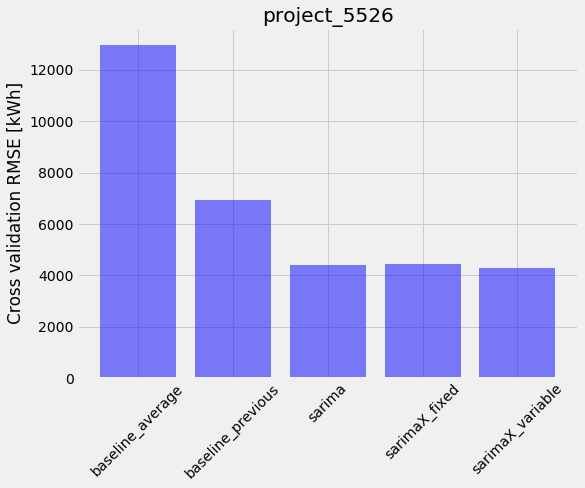

In [124]:
plot_results(results_train)

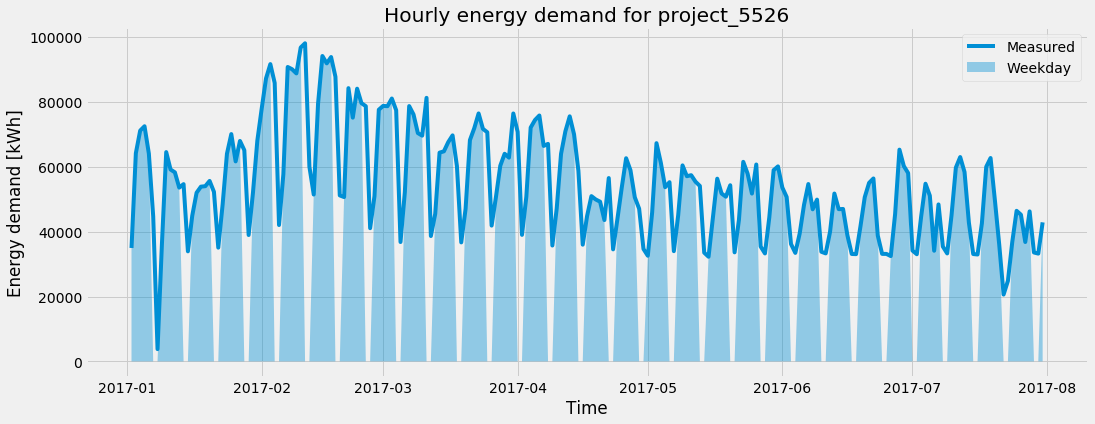

In [51]:
plt.figure(figsize=(16,6))
y_plot = y.iloc[:,0]/1000.
plt.plot(y.index, y_plot,label='Measured')
plt.fill_between(y.index, y.iloc[:,-1]*y_plot, alpha=0.4, label='Weekday')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Energy demand [kWh]')
title = 'Hourly energy demand for {}'.format(project_name)
plt.title(title)
plt.show()

## T-dependance

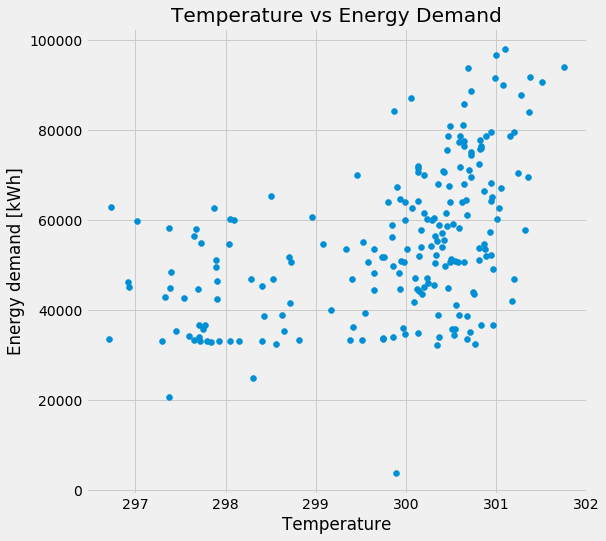

In [52]:
plt.figure(figsize=(8,8))
y_plot = y.iloc[:,0]/1000
plt.scatter(y.iloc[:,1], y_plot)
plt.xlabel('Temperature')
plt.ylabel('Energy demand [kWh]')
title = 'Temperature vs Energy Demand'.format(project_name)
plt.title(title)
plt.show()

In [53]:
y_train = y[:-2*season]
y_test = y[-2*season:]

In [54]:
endog = y_train.ix[:,0]
exog = sm.add_constant(y_train.ix[:,1:])

/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


## Training

In [74]:
predictions = []
window = 35

In [60]:
prediction_b1, prediction_b2 = baseline_forecasts(y,len(y)-window,'D')


baseline - previous...
Baseline-previous test RMSE 13443084.1327
baseline - averages....
Baseline-averages test RMSE 14291224.5565


In [75]:
predictions.append(['baseline_previous',prediction_b1])
predictions.append(['baseline_average',prediction_b2])

In [71]:
sp = Sarima_predictions(params_s)
results_s = sp.rolling_predictions_sarima(y,window,len(y)-window,types=0)
sp = Sarima_predictions(params_sX)
results_sX = sp.rolling_predictions_sarima(y,window,len(y)-window,types=2)
sp = Sarima_predictions(params_sX_v)
results_sX_v = sp.rolling_predictions_sarima(y,window,len(y)-window,types=2)

In [76]:
prediction_s = results_s['sarima'][0]
prediction_sX = results_sX['sarimaX'][0]
prediction_sX_v = results_sX_v['sarimaX'][0]

In [77]:
predictions.append(['sarima',prediction_s])
predictions.append(['sarimaX_f',prediction_sX])
predictions.append(['sarimaX_v',prediction_sX_v])

In [78]:
for p in predictions:
    p[1] = p[1][3:]
    

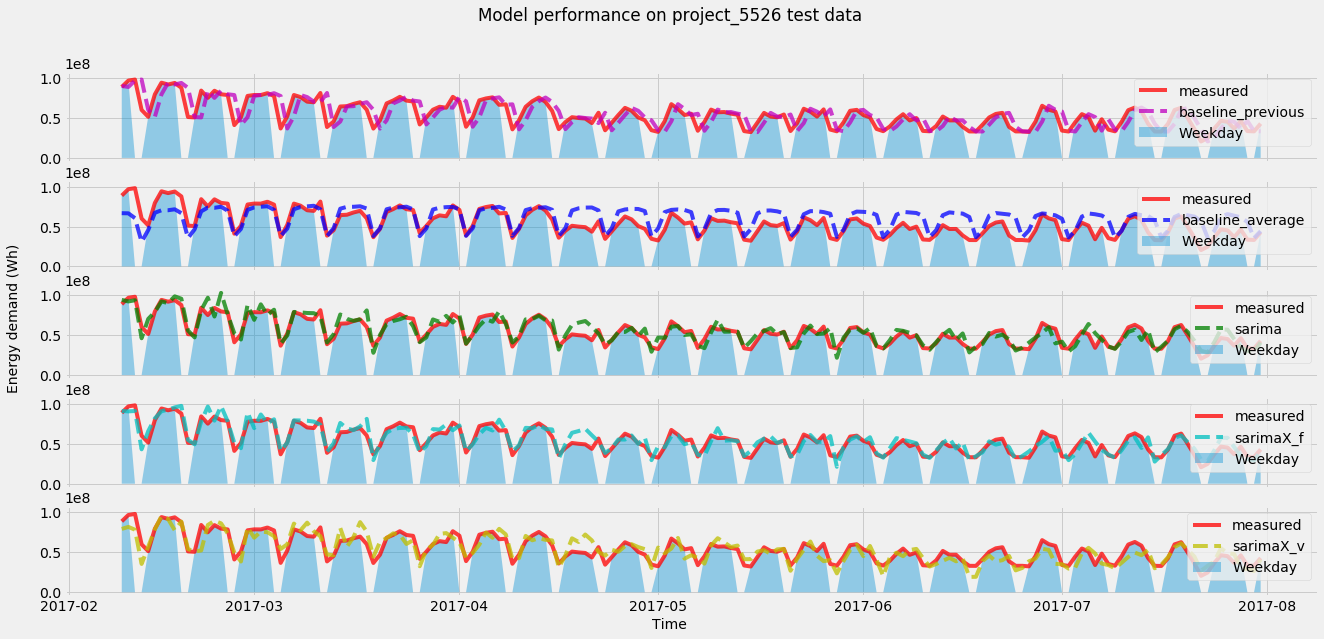

In [79]:
line_plot_predictions(project_name, predictions,y.iloc[window+3:])

In [82]:
sp = Sarima_predictions(params_sX)
model = sp.fit_sarimaX((y_train.iloc[:,0],y_train.iloc[:,1:]))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         power_all   No. Observations:                  197
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -3130.344
Date:                           Sat, 02 Sep 2017   AIC                           6272.687
Time:                                   14:21:59   BIC                           6292.386
Sample:                               01-02-2017   HQIC                          6280.662
                                    - 07-17-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T-1        -2.767e+05   1.07e+06     -0.258      0.797   -2.38e+06    1.83e+06
weekday     2.772e-10    270.086   1.03e-12      1.000    -529.358     529.358
ma.L1          0.4782      0.077      6.176      0.000       0.326       0.630
ar.S.L7       -0.2779      0.228     -1.220      0.222      -0.724       0.168
ma.S.L7       -0.0559      0.220     -0.254      0.799      -0.486       0.374
sigma2      7.199e+13      0.036   1.98e+15      0.000     7.2e+13     7.2e+13
===================================================================================
Ljung-Box (Q):                      101.31   Jarque-Bera (JB):                 2.82
Prob(Q):                              0.00   Prob(JB):                         0.24
Heteroskedasticity (H):               0.69   Skew:                            -0.14
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.31e+31. Standard errors may be unstable.
"""

## Forecasts

In [83]:
forecasts = []

In [84]:
forecast_b1, forecast_b2 = baseline_forecasts(y,2*season,'D')


baseline - previous...
Baseline-previous test RMSE 10596233.8684
baseline - averages....
Baseline-averages test RMSE 18000876.6597


In [85]:
forecasts.append(['baseline_previous',forecast_b1])
forecasts.append(['baseline_average',forecast_b2])

In [88]:
sp = Sarima_predictions(params_s)
results_s = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=0)
sp = Sarima_predictions(params_sX)
results_sX = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=2)
sp = Sarima_predictions(params_sX_v)
results_sX_v = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=2, var=True)

In [89]:
forecast_s = results_s['sarima'][0]
forecast_sX = results_sX['sarimaX'][0]
forecast_sX_v = results_sX_v['sarimaX'][0]

In [90]:
forecasts.append(['sarima',forecast_s])
forecasts.append(['sarimaX_f',forecast_sX])
forecasts.append(['sarimaX_f',forecast_sX_v])

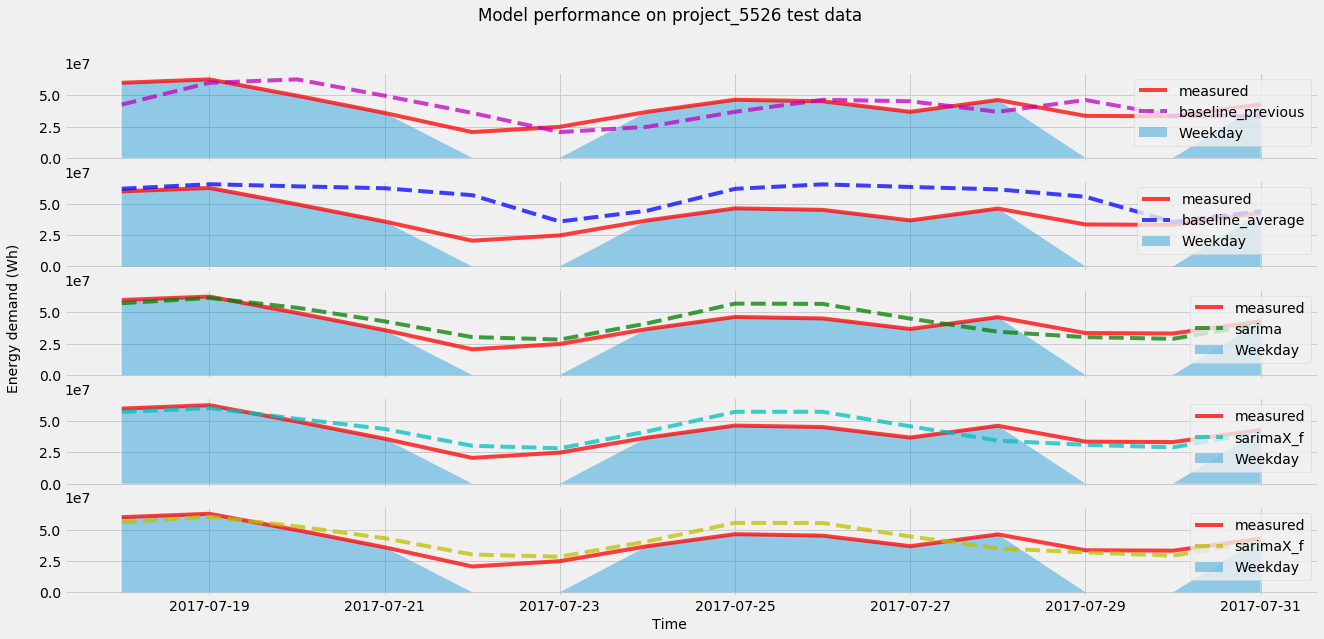

In [91]:
line_plot_predictions(project_name, forecasts,y_test)